<a href="https://colab.research.google.com/github/samarranjit/Yield_Prediction/blob/main/Dense_Neural_Network_For_Yield_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Deep Learning Models on the yield Dataset

### Importing the libraries, and dataset

In [ ]:
!pip install rasterio -q
!pip install whitebox -q
!pip install tqdm -q
!pip install tqdm_joblib -q
!pip install xgboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 2.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'rasterio'

In [3]:
soy_fn = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_soybeans_absolute_all_years_with_divided_precipitation.parquet"
corn_fn = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_corn_absolute_all_years_with_divided_precipitation.parquet"
wheat_fn = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_wheat_absolute_all_years_with_divided_precipitation2.parquet"

df_soybeans = pd.read_parquet(soy_fn)
df_corn = pd.read_parquet(corn_fn)
df_wheat = pd.read_parquet(wheat_fn)

print(df_soybeans.describe())
print(df_corn.describe())
print(df_wheat.describe())

                   x             y          yield           year  \
count  611315.000000  6.113150e+05  611315.000000  611315.000000   
mean   337339.638666  4.321327e+06      46.694985    2019.207328   
std      2571.816114  8.672437e+02      16.998010       2.978032   
min    330893.532259  4.318616e+06       4.139045    2014.000000   
25%    336099.599602  4.320616e+06      34.509420    2017.000000   
50%    336840.073515  4.321341e+06      46.845428    2019.000000   
75%    339214.129061  4.321947e+06      59.010979    2022.000000   
max    342733.656286  4.323242e+06     116.790192    2024.000000   

           ndvi_mean       ndvi_max     ndvi_range   lst_median_k  \
count  611315.000000  611315.000000  611315.000000  611315.000000   
mean        0.546852       0.867373       0.598420     301.906139   
std         0.084386       0.079921       0.153782       3.212771   
min         0.253719       0.324230       0.000000     289.562653   
25%         0.493608       0.840899       

### Cleaning dataset

In [4]:
df_soybeans = df_soybeans[df_soybeans['gi_max'] < df_soybeans['gi_max'].quantile(0.98)]
df_wheat = df_wheat[df_wheat['gi_max'] < df_wheat['gi_max'].quantile(0.98)]
df_corn = df_corn[df_corn['gi_max'] < df_corn['gi_max'].quantile(0.98)]

In [5]:
df_wheat = df_wheat[(df_wheat["yield"] < df_wheat["yield"].quantile(0.98)) & (df_wheat["yield"] > df_wheat["yield"].quantile(0.02))]
df_soybeans = df_soybeans[(df_soybeans["yield"] < df_soybeans["yield"].quantile(0.98)) & (df_soybeans["yield"] > df_soybeans["yield"].quantile(0.02))]
df_corn = df_corn[(df_corn["yield"] < df_corn["yield"].quantile(0.98)) & (df_corn["yield"] > df_corn["yield"].quantile(0.02))]

In [6]:
df = df_wheat.copy()
df['elevation_squared'] = df['elevation'] ** 2
df['slope_squared'] = df['slope'] ** 2
df['elev_slope'] = df['elevation'] * df['slope']
df['elev_aspect'] = df['elevation'] * df['aspect']
df['slope_aspect'] = df['slope'] * df['aspect']


df['ndvi_pr'] = df['ndvi_mean'] * df['pr_season_mm']

df['aspect_southness'] = 1 - np.abs((df['aspect'] - 180) / 180)
df.info()

df_wheat = df.copy()

<class 'pandas.core.frame.DataFrame'>
Index: 173073 entries, 262 to 21167
Data columns (total 64 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   x                       173073 non-null  float64
 1   y                       173073 non-null  float64
 2   yield                   173073 non-null  float64
 3   field                   173073 non-null  object 
 4   year                    173073 non-null  int64  
 5   elevation               173073 non-null  float32
 6   slope                   173073 non-null  float32
 7   aspect                  173073 non-null  float32
 8   ndvi_mean               173073 non-null  float64
 9   ndvi_max                173073 non-null  float64
 10  ndvi_range              173073 non-null  float64
 11  lst_median_k            173073 non-null  float64
 12  lst_range_k             173073 non-null  float64
 13  lst_max_k               173073 non-null  float64
 14  pr_season_mm            

In [ ]:
from sklearn.preprocessing import StandardScaler

# scaling the variables that need scaling

need_std = [
    "elevation", "slope", "aspect",
    "slope_squared", "elevation_squared",
    "elev_slope", "elev_aspect", "slope_aspect",
    "lst_median_k", "lst_range_k", "lst_max_k",
    "pr_season_mm", "pr_mean_mm_day", "pr_max_mm_day", "pr_range_mm_day",
    "clay_pct", "ksat", "ndvi_pr", "gi_mean", "gi_max", "gi_range",
     'fall_aridity', 'fall_pr_max_mm_day', 'fall_pr_mean_mm_day',
       'fall_pr_range_mm_day', 'fall_pr_season_mm', 'spring_aridity',
       'spring_pr_max_mm_day', 'spring_pr_mean_mm_day',
       'spring_pr_range_mm_day', 'spring_pr_season_mm', 'summer_aridity',
       'summer_pr_max_mm_day', 'summer_pr_mean_mm_day',
       'summer_pr_range_mm_day', 'summer_pr_season_mm', 'winter_aridity',
       'winter_pr_max_mm_day', 'winter_pr_mean_mm_day',
       'winter_pr_range_mm_day', 'winter_pr_season_mm'

]

# Copy full dataset
df_wheat_scaled = df_wheat.copy()

# Fit scaler on all years (2014–2024)
scaler = StandardScaler()
df_wheat_scaled[need_std] = scaler.fit_transform(df_wheat_scaled[need_std])

need_std = [
    "elevation", "slope", "aspect",
    "slope_squared", "elevation_squared",
    "elev_slope", "elev_aspect", "slope_aspect",
    "lst_median_k", "lst_range_k", "lst_max_k",
    "pr_season_mm", "pr_mean_mm_day", "pr_max_mm_day", "pr_range_mm_day",
    "clay_pct", "ksat", "ndvi_pr", "gi_mean", "gi_max", "gi_range",
     'fall_aridity', 'fall_pr_max_mm_day', 'fall_pr_mean_mm_day',
       'fall_pr_range_mm_day', 'fall_pr_season_mm', 'spring_aridity',
       'spring_pr_max_mm_day', 'spring_pr_mean_mm_day',
       'spring_pr_range_mm_day', 'spring_pr_season_mm', 'summer_aridity',
       'summer_pr_max_mm_day', 'summer_pr_mean_mm_day',
       'summer_pr_range_mm_day', 'summer_pr_season_mm'

]

# Copy full dataset
df_soybeans_scaled = df_soybeans.copy()

# Fit scaler on all years (2014–2024)
scaler = StandardScaler()
df_soybeans_scaled[need_std] = scaler.fit_transform(df_soybeans_scaled[need_std])



# Copy full dataset
df_corn_scaled = df_corn.copy()

# Fit scaler on all years (2014–2024)
scaler = StandardScaler()
df_corn_scaled[need_std] = scaler.fit_transform(df_corn_scaled[need_std])


### -----------------------------------------------------------

### Getting a subset of dataset

In [30]:
# ==== SIMPLE SAMPLER (run this first) ====
import numpy as np
import pandas as pd

# ---- USER KNOBS (edit these) ----
SEED = 42
TARGET_COL = "yield"
FIELD_COL  = "field"
YEAR_COL   = "year"

SAMPLE_SIZE_TARGET = 50_000   # typical: 50k (try 80k–100k if you have resources)
MIN_PER_GROUP      = 130      # ensure coverage per field×year
MAX_PER_GROUP      = 1000     # avoid domination by big groups
BASE_FRAC          = 0.10     # start by taking ~10% from each group
# --------------------------------

rng = np.random.default_rng(SEED)
df = df_soybeans.copy()

# Build group key
df["field_year"] = df[FIELD_COL].astype(str) + "_" + df[YEAR_COL].astype(str)

# Group sizes and initial allocation
gsize = df.groupby("field_year").size()
alloc = np.ceil(gsize * BASE_FRAC).astype(int)
alloc = alloc.clip(lower=MIN_PER_GROUP, upper=MAX_PER_GROUP)
alloc = np.minimum(alloc, gsize)  # cannot exceed what's available

# Simple adjuster to match SAMPLE_SIZE_TARGET (no fancy math; easy to read)
def adjust_allocation_simple(alloc, target, gsize, min_k, max_k):
    alloc = alloc.copy()
    total = int(alloc.sum())

    # Scale DOWN by peeling 1 at a time from the largest groups (above min_k)
    while total > target:
        # candidates that can give 1 back
        can_give = alloc[alloc > min_k]
        if can_give.empty:
            break
        idx = can_give.sort_values(ascending=False).index[0]
        alloc.loc[idx] -= 1
        total -= 1

    # Scale UP by adding 1 at a time to groups with headroom
    while total < target:
        headroom = (np.minimum(max_k, gsize) - alloc)
        can_take = headroom[headroom > 0]
        if can_take.empty:
            break
        # give to the group currently smallest (for balance)
        idx = (alloc.loc[can_take.index]).sort_values(ascending=True).index[0]
        alloc.loc[idx] += 1
        total += 1

    return alloc

alloc = adjust_allocation_simple(
    alloc=alloc,
    target=SAMPLE_SIZE_TARGET,
    gsize=gsize,
    min_k=MIN_PER_GROUP,
    max_k=MAX_PER_GROUP
)

# Draw samples per group (reproducible)
sampled_parts = []
for gy, k in alloc.items():
    if k <= 0:
        continue
    gdf = df[df["field_year"] == gy]
    sampled_parts.append(gdf.sample(n=int(k), random_state=SEED, replace=False))

sampled_tuning_set = pd.concat(sampled_parts, ignore_index=True)

# Quick report
total_groups = df["field_year"].nunique()
covered_groups = sampled_tuning_set["field_year"].nunique()
per_group_counts = sampled_tuning_set.groupby("field_year").size()

print("=== Sampling Summary ===")
print(f"Requested size: {SAMPLE_SIZE_TARGET:,}")
print(f"Actual size:    {len(sampled_tuning_set):,}")
print(f"Groups covered: {covered_groups}/{total_groups} "
      f"({covered_groups/total_groups*100:.1f}%)")
print(f"Median per-group sample: {int(per_group_counts.median())}")

# Keep only what we need going forward (optional but tidy)
# sampled_tuning_set now holds your training sample for cell 2.


=== Sampling Summary ===
Requested size: 50,000
Actual size:    50,075
Groups covered: 386/386 (100.0%)
Median per-group sample: 130


In [ ]:
df_soybeans_scaled.keys()

Index(['x', 'y', 'yield', 'field', 'year', 'ndvi_mean', 'ndvi_max',
       'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'theta_s', 'clay_pct', 'ksat', 'evi_mean', 'evi_max',
       'evi_range', 'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean', 'ndwi_max',
       'ndwi_range', 'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range',
       'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range', 'elevation', 'slope',
       'aspect', 'elevation_squared', 'slope_squared', 'elev_slope',
       'elev_aspect', 'slope_aspect', 'ndvi_pr', 'aspect_southness',
       'fall_aridity', 'fall_pr_max_mm_day', 'fall_pr_mean_mm_day',
       'fall_pr_range_mm_day', 'fall_pr_season_mm', 'spring_aridity',
       'spring_pr_max_mm_day', 'spring_pr_mean_mm_day',
       'spring_pr_range_mm_day', 'spring_pr_season_mm', 'summer_aridity',
       'summer_pr_max_mm_day', 'summer_pr_mean_mm_day',
       'summer_pr_range_mm

In [ ]:
# ---- GPU / mixed-precision setup ----
import tensorflow as tf, os
print("TF sees GPUs:", tf.config.list_physical_devices("GPU"))

# Let TF grow GPU memory as needed (instead of grabbing all at once)
for g in tf.config.list_physical_devices("GPU"):
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception as e:
        print("Memory growth not set:", e)

# Mixed precision = faster on modern GPUs (T4, A100, etc.)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
print("Compute dtype policy:", mixed_precision.global_policy())


TF sees GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Compute dtype policy: <DTypePolicy "mixed_float16">


### Let's Try DNN:

In [10]:
# Add this code to verify GPU usage
import tensorflow as tf

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Get GPU details
if tf.config.list_physical_devices('GPU'):
    print("GPU Details:")
    !nvidia-smi

# Check TensorFlow is using GPU
print("\nTensorFlow built with CUDA:", tf.test.is_built_with_cuda())
print("GPU Available to TensorFlow:", tf.test.is_gpu_available())

Num GPUs Available:  1
GPU Details:
Wed Nov 12 03:27:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P0             30W /   70W |     102MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------

In [31]:
df_soybeans_copy = df_soybeans.copy()
df_soybeans = sampled_tuning_set.copy()

In [ ]:
temp = df_soybeans.copy()
df_soybeans_copy = df_soybeans.copy()
df_soybeans = temp.copy()

In [12]:
df_soybeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50075 entries, 0 to 50074
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   x                       50075 non-null  float64
 1   y                       50075 non-null  float64
 2   yield                   50075 non-null  float64
 3   field                   50075 non-null  object 
 4   year                    50075 non-null  int64  
 5   ndvi_mean               50075 non-null  float64
 6   ndvi_max                50075 non-null  float64
 7   ndvi_range              50075 non-null  float64
 8   lst_median_k            50075 non-null  float64
 9   lst_range_k             50075 non-null  float64
 10  lst_max_k               50075 non-null  float64
 11  pr_season_mm            50075 non-null  float64
 12  pr_mean_mm_day          50075 non-null  float64
 13  pr_max_mm_day           50075 non-null  float64
 14  pr_range_mm_day         50075 non-null

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
DEEP NEURAL NETWORK FOR SOYBEAN YIELD PREDICTION

Using 53 features: ['ndvi_mean', 'ndvi_max', 'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k', 'pr_season_mm', 'pr_max_mm_day', 'pr_range_mm_day', 'aridity', 'theta_s', 'clay_pct', 'ksat', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range', 'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range', 'elevation', 'slope', 'aspect', 'elevation_squared', 'slope_squared', 'elev_slope', 'elev_aspect', 'slope_aspect', 'ndvi_pr', 'aspect_southness', 'fall_aridity', 'fall_pr_max_mm_day', 'fall_pr_mean_mm_day', 'fall_pr_range_mm_day', 'fall_pr_season_mm', 'spring_aridity', 'spring_pr_max_mm_day', 'spring_pr_mean_mm_day', 'spring_pr_range_mm_day', 'spring_pr_season_mm', 'summer_aridity', 'summer_pr_max_mm_day', 'summer_pr_mean_mm_day',

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_117 (Dense)               │ (None, 256)            │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_93          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,833 (222.00 KB)

 Trainable params: 55,937 (218.50 KB)

 Non-trainable params: 896 (3.50 KB)


Training with parameters:
  hidden_layers: [256, 128, 64]
  dropout_rate: 0.35
  l1_reg: 0.0
  l2_reg: 0.001
  learning_rate: 0.0001
  batch_size: 2048
  epochs: 500
  activation: relu
Epoch 1/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 1.5454 - mae: 1.0454 - mse: 2.5139

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - loss: 1.5436 - mae: 1.0435 - mse: 2.5073 - val_loss: 1.1266 - val_mae: 0.5617 - val_mse: 0.5197 - learning_rate: 1.0000e-04
Epoch 2/500
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4333 - mae: 0.9263 - mse: 2.1563 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4276 - mae: 0.9200 - mse: 2.1283 - val_loss: 1.0789 - val_mae: 0.5117 - val_mse: 0.4048 - learning_rate: 1.0000e-04
Epoch 3/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3644 - mae: 0.8521 - mse: 1.9047 - val_loss: 1.0790 - val_mae: 0.5217 - val_mse: 0.4105 - learning_rate: 1.0000e-04
Epoch 4/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3156 - mae: 0.8017 - mse: 1.8879 - val_loss: 1.0796 - val_mae: 0.5320 - val_mse: 0.4204 - learning_rate: 1.0000e-04
Epoch 5/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2841 - mae: 0.7711 - mse: 1.5222 - val_loss: 1.0743 - val_mae: 0.5334 - val_mse: 0.4187 - learning_rate: 1.0000e-04
Epoch 6/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2534 - mae: 0.7381 - mse: 1.7663 - val_loss: 1.0666 - val_mae: 0.5301 - val_mse: 0.4122 - learning_rate: 1.0000e-04
Epoch 7/500
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2347 - mae: 0.7233 - mse: 1.3673 
Epoch 7: ReduceLROnPlateau redu

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1894 - mae: 0.6822 - mse: 0.9773 - val_loss: 1.0426 - val_mae: 0.5113 - val_mse: 0.3886 - learning_rate: 5.0000e-05
Epoch 11/500
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1724 - mae: 0.6618 - mse: 0.9958 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1719 - mae: 0.6614 - mse: 1.0097 - val_loss: 1.0383 - val_mae: 0.5081 - val_mse: 0.3853 - learning_rate: 5.0000e-05
Epoch 12/500
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1678 - mae: 0.6602 - mse: 1.1259 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1673 - mae: 0.6597 - mse: 1.1257 - val_loss: 1.0338 - val_mae: 0.5038 - val_mse: 0.3819 - learning_rate: 5.0000e-05
Epoch 13/500
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1538 - mae: 0.6448 - mse: 1.0974 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1518 - mae: 0.6427 - mse: 1.0694 - val_loss: 1.0310 - val_mae: 0.5027 - val_mse: 0.3818 - learning_rate: 5.0000e-05
Epoch 14/500
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1497 - mae: 0.6440 - mse: 0.9710 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1497 - mae: 0.6442 - mse: 0.9889 - val_loss: 1.0279 - val_mae: 0.5008 - val_mse: 0.3810 - learning_rate: 5.0000e-05
Epoch 15/500
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1464 - mae: 0.6453 - mse: 0.8410 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1449 - mae: 0.6432 - mse: 0.8677 - val_loss: 1.0244 - val_mae: 0.4984 - val_mse: 0.3796 - learning_rate: 5.0000e-05
Epoch 16/500
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1304 - mae: 0.6252 - mse: 0.9353 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1307 - mae: 0.6258 - mse: 0.9547 - val_loss: 1.0209 - val_mae: 0.4959 - val_mse: 0.3782 - learning_rate: 5.0000e-05
Epoch 17/500
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1270 - mae: 0.6255 - mse: 0.8578 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1266 - mae: 0.6251 - mse: 0.8632 - val_loss: 1.0180 - val_mae: 0.4954 - val_mse: 0.3780 - learning_rate: 5.0000e-05
Epoch 18/500
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1137 - mae: 0.6128 - mse: 0.8720 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1130 - mae: 0.6119 - mse: 0.8875 - val_loss: 1.0145 - val_mae: 0.4928 - val_mse: 0.3765 - learning_rate: 5.0000e-05
Epoch 19/500
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1002 - mae: 0.5961 - mse: 0.9335 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1009 - mae: 0.5973 - mse: 0.9394 - val_loss: 1.0115 - val_mae: 0.4911 - val_mse: 0.3763 - learning_rate: 5.0000e-05
Epoch 20/500
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1016 - mae: 0.6036 - mse: 0.8306 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1003 - mae: 0.6022 - mse: 0.8279 - val_loss: 1.0056 - val_mae: 0.4874 - val_mse: 0.3685 - learning_rate: 5.0000e-05
Epoch 21/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0854 - mae: 0.5852 - mse: 0.6977 - val_loss: 1.0035 - val_mae: 0.4881 - val_mse: 0.3698 - learning_rate: 5.0000e-05
Epoch 22/500
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0812 - mae: 0.5849 - mse: 0.7813 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0818 - mae: 0.5855 - mse: 0.7891 - val_loss: 1.0003 - val_mae: 0.4865 - val_mse: 0.3689 - learning_rate: 5.0000e-05
Epoch 23/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0738 - mae: 0.5788 - mse: 0.7012 - val_loss: 0.9978 - val_mae: 0.4866 - val_mse: 0.3693 - learning_rate: 5.0000e-05
Epoch 24/500
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0661 - mae: 0.5702 - mse: 0.7846 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0661 - mae: 0.5705 - mse: 0.7786 - val_loss: 0.9945 - val_mae: 0.4847 - val_mse: 0.3684 - learning_rate: 5.0000e-05
Epoch 25/500
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0668 - mae: 0.5763 - mse: 0.6684 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0666 - mae: 0.5761 - mse: 0.6783 - val_loss: 0.9920 - val_mae: 0.4841 - val_mse: 0.3693 - learning_rate: 5.0000e-05
Epoch 26/500
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0604 - mae: 0.5705 - mse: 0.6556 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0600 - mae: 0.5704 - mse: 0.6553 - val_loss: 0.9890 - val_mae: 0.4837 - val_mse: 0.3684 - learning_rate: 5.0000e-05
Epoch 27/500
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0464 - mae: 0.5548 - mse: 0.7286 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0462 - mae: 0.5547 - mse: 0.7213 - val_loss: 0.9857 - val_mae: 0.4829 - val_mse: 0.3671 - learning_rate: 5.0000e-05
Epoch 28/500
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0416 - mae: 0.5530 - mse: 0.5914 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0414 - mae: 0.5529 - mse: 0.5913 - val_loss: 0.9816 - val_mae: 0.4801 - val_mse: 0.3645 - learning_rate: 5.0000e-05
Epoch 29/500
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0445 - mae: 0.5602 - mse: 0.6686 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0436 - mae: 0.5592 - mse: 0.6680 - val_loss: 0.9787 - val_mae: 0.4794 - val_mse: 0.3642 - learning_rate: 5.0000e-05
Epoch 30/500
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0344 - mae: 0.5510 - mse: 0.6731 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0347 - mae: 0.5512 - mse: 0.6788 - val_loss: 0.9759 - val_mae: 0.4790 - val_mse: 0.3640 - learning_rate: 5.0000e-05
Epoch 31/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0363 - mae: 0.5554 - mse: 0.8245 - val_loss: 0.9733 - val_mae: 0.4832 - val_mse: 0.3623 - learning_rate: 5.0000e-05
Epoch 32/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0191 - mae: 0.5381 - mse: 0.6051 - val_loss: 0.9696 - val_mae: 0.4810 - val_mse: 0.3606 - learning_rate: 5.0000e-05
Epoch 33/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0122 - mae: 0.5327 - mse: 0.6050 - val_loss: 0.9679 - val_mae: 0.4819 - val_mse: 0.3628 - learning_rate: 5.0000e-05
Epoch 34/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0161 - mae: 0.5400 - mse: 0.6955 - val_loss: 0.9657 - val_mae: 0.4826 - val_mse: 0.3640 - learning_rate: 5.0000e-05
Epoch 35/500
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0096 - mae: 0.5352 - mse: 0.5949 
Epoch 35: ReduceLROnPlatea

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9957 - mae: 0.5237 - mse: 0.6257 - val_loss: 0.9572 - val_mae: 0.4790 - val_mse: 0.3610 - learning_rate: 2.5000e-05
Epoch 39/500
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9952 - mae: 0.5244 - mse: 0.5687 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9960 - mae: 0.5254 - mse: 0.5855 - val_loss: 0.9555 - val_mae: 0.4781 - val_mse: 0.3604 - learning_rate: 2.5000e-05
Epoch 40/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0029 - mae: 0.5367 - mse: 0.7039 - val_loss: 0.9561 - val_mae: 0.4820 - val_mse: 0.3641 - learning_rate: 2.5000e-05
Epoch 41/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9940 - mae: 0.5272 - mse: 0.5908 - val_loss: 0.9548 - val_mae: 0.4816 - val_mse: 0.3646 - learning_rate: 2.5000e-05
Epoch 42/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9860 - mae: 0.5174 - mse: 0.6041 - val_loss: 0.9535 - val_mae: 0.4818 - val_mse: 0.3647 - learning_rate: 2.5000e-05
Epoch 43/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9880 - mae: 0.5209 - mse: 0.6626 - val_loss: 0.9522 - val_mae: 0.4812 - val_mse: 0.3651 - learning_rate: 2.5000e-05
Epoch 44/500
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9849 - mae: 0.5180 - mse: 0.6796 
Epoch 44: ReduceLROnPlatea

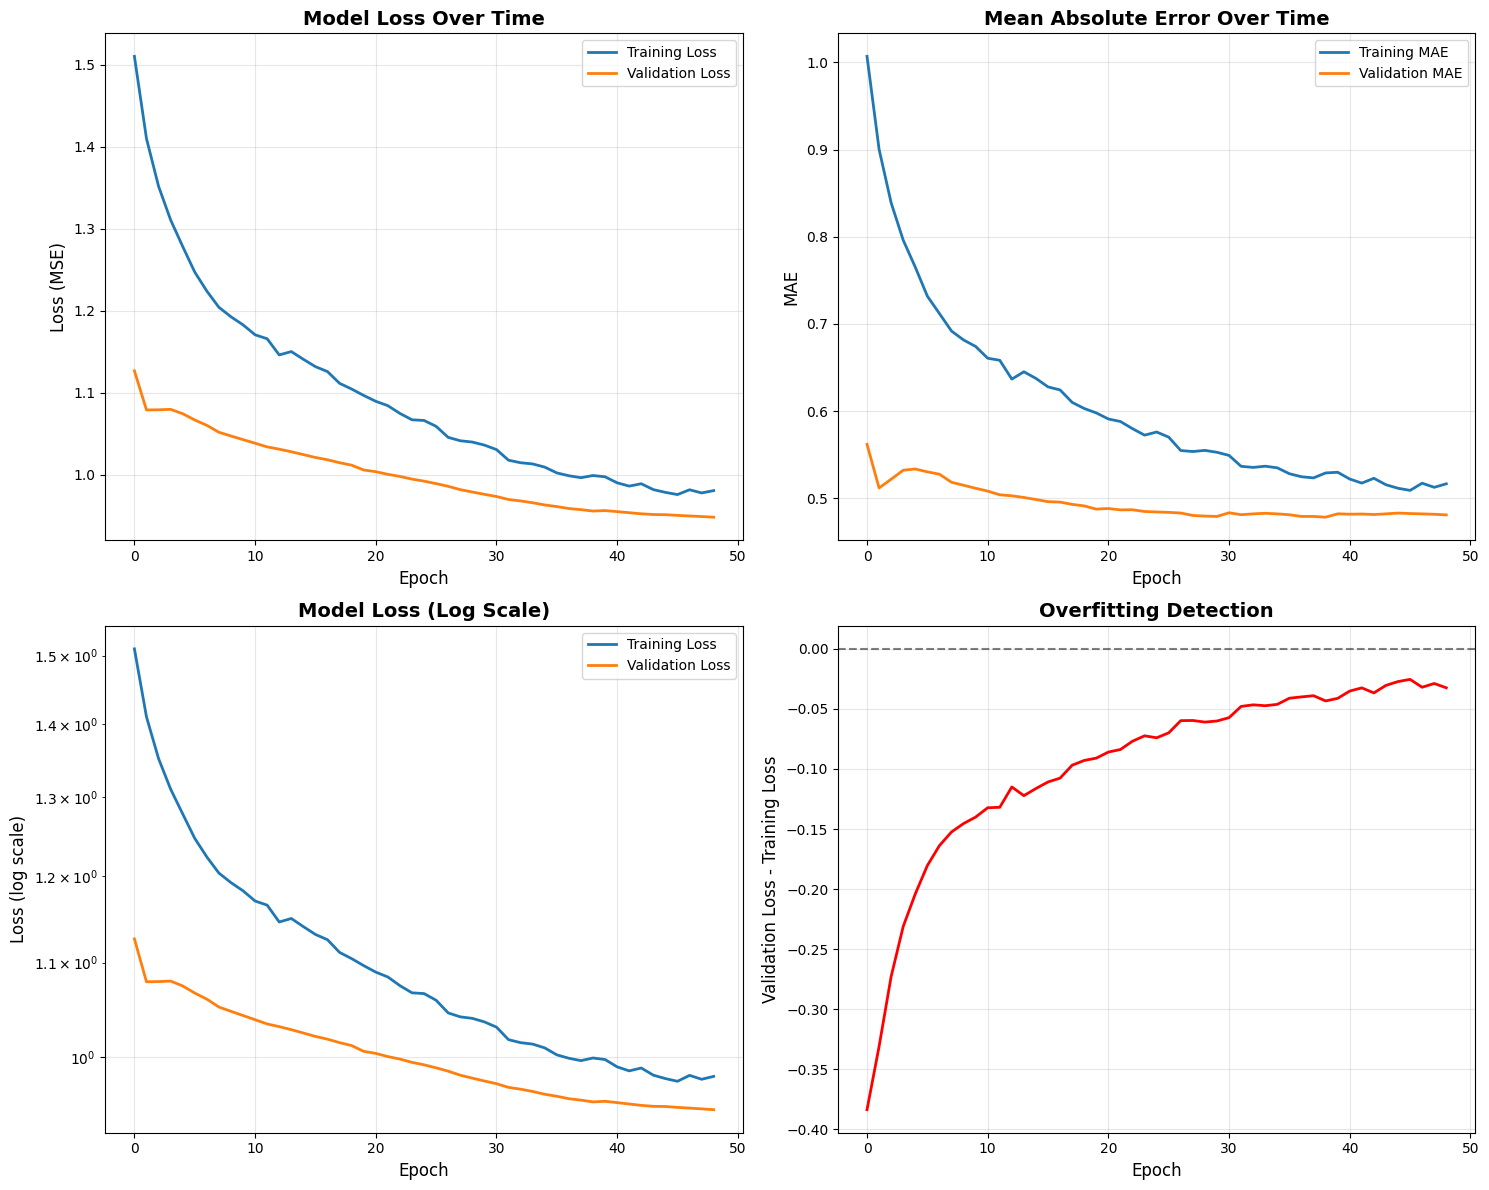


2. Predictions Analysis...


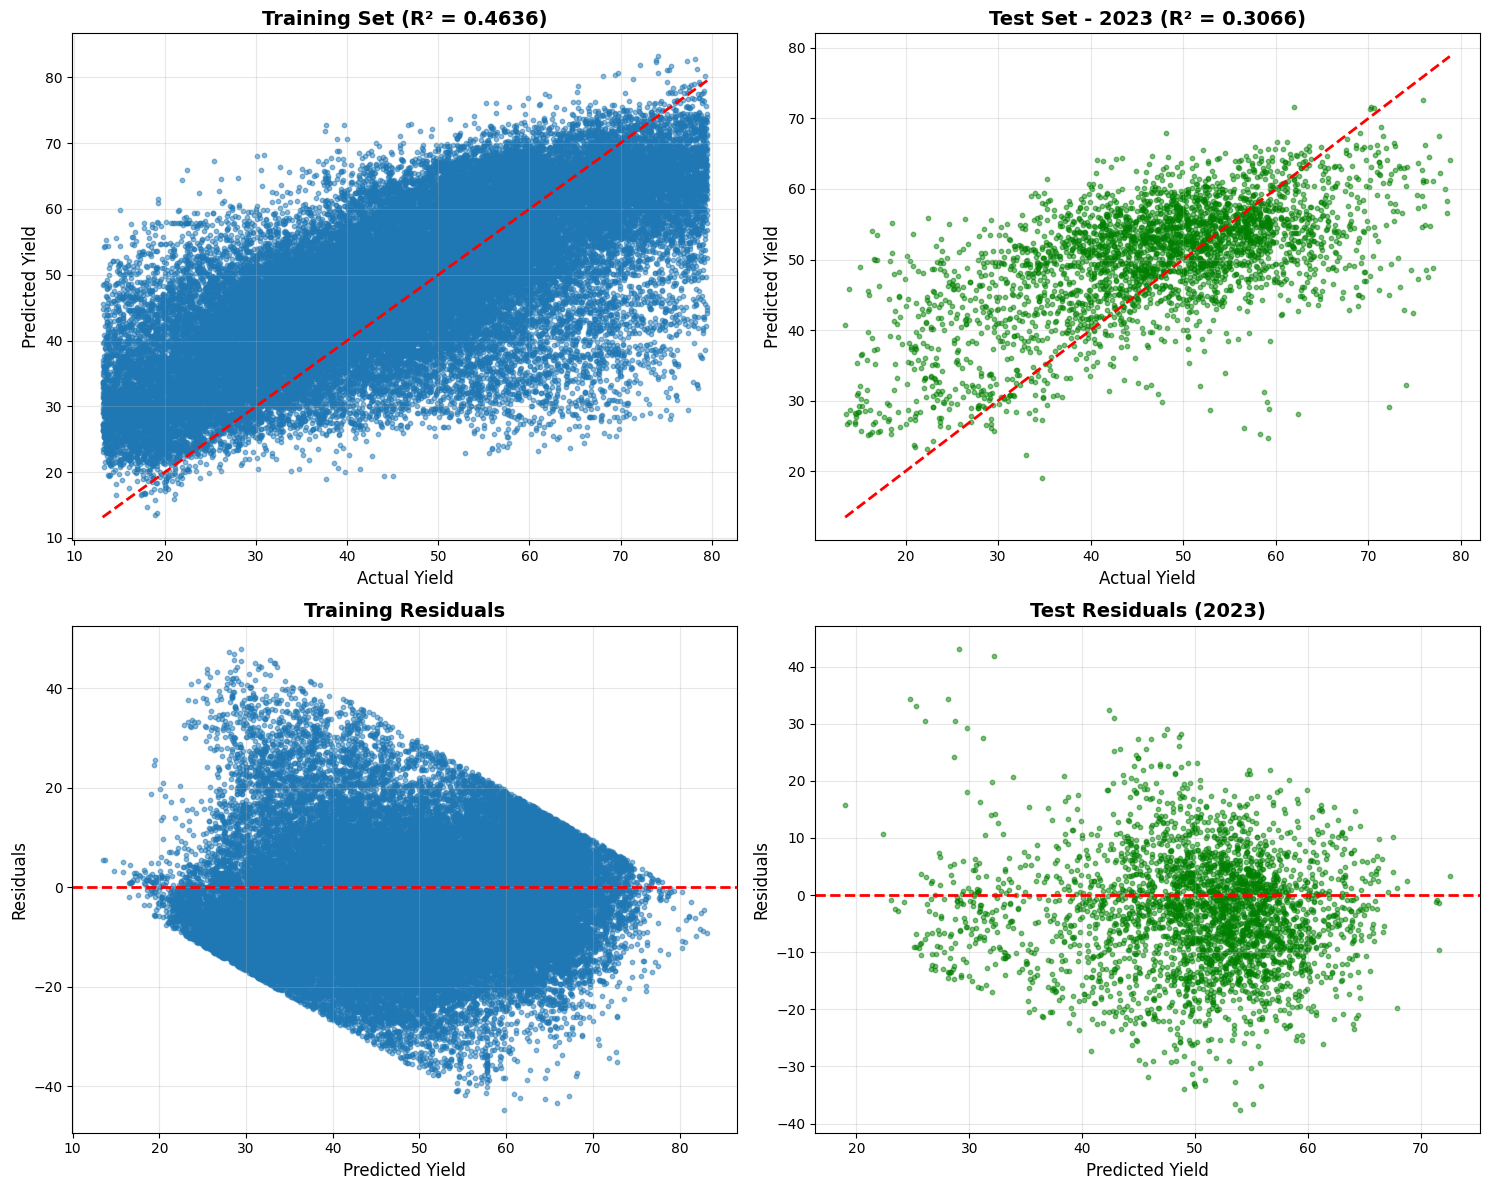


3. Error Distribution...


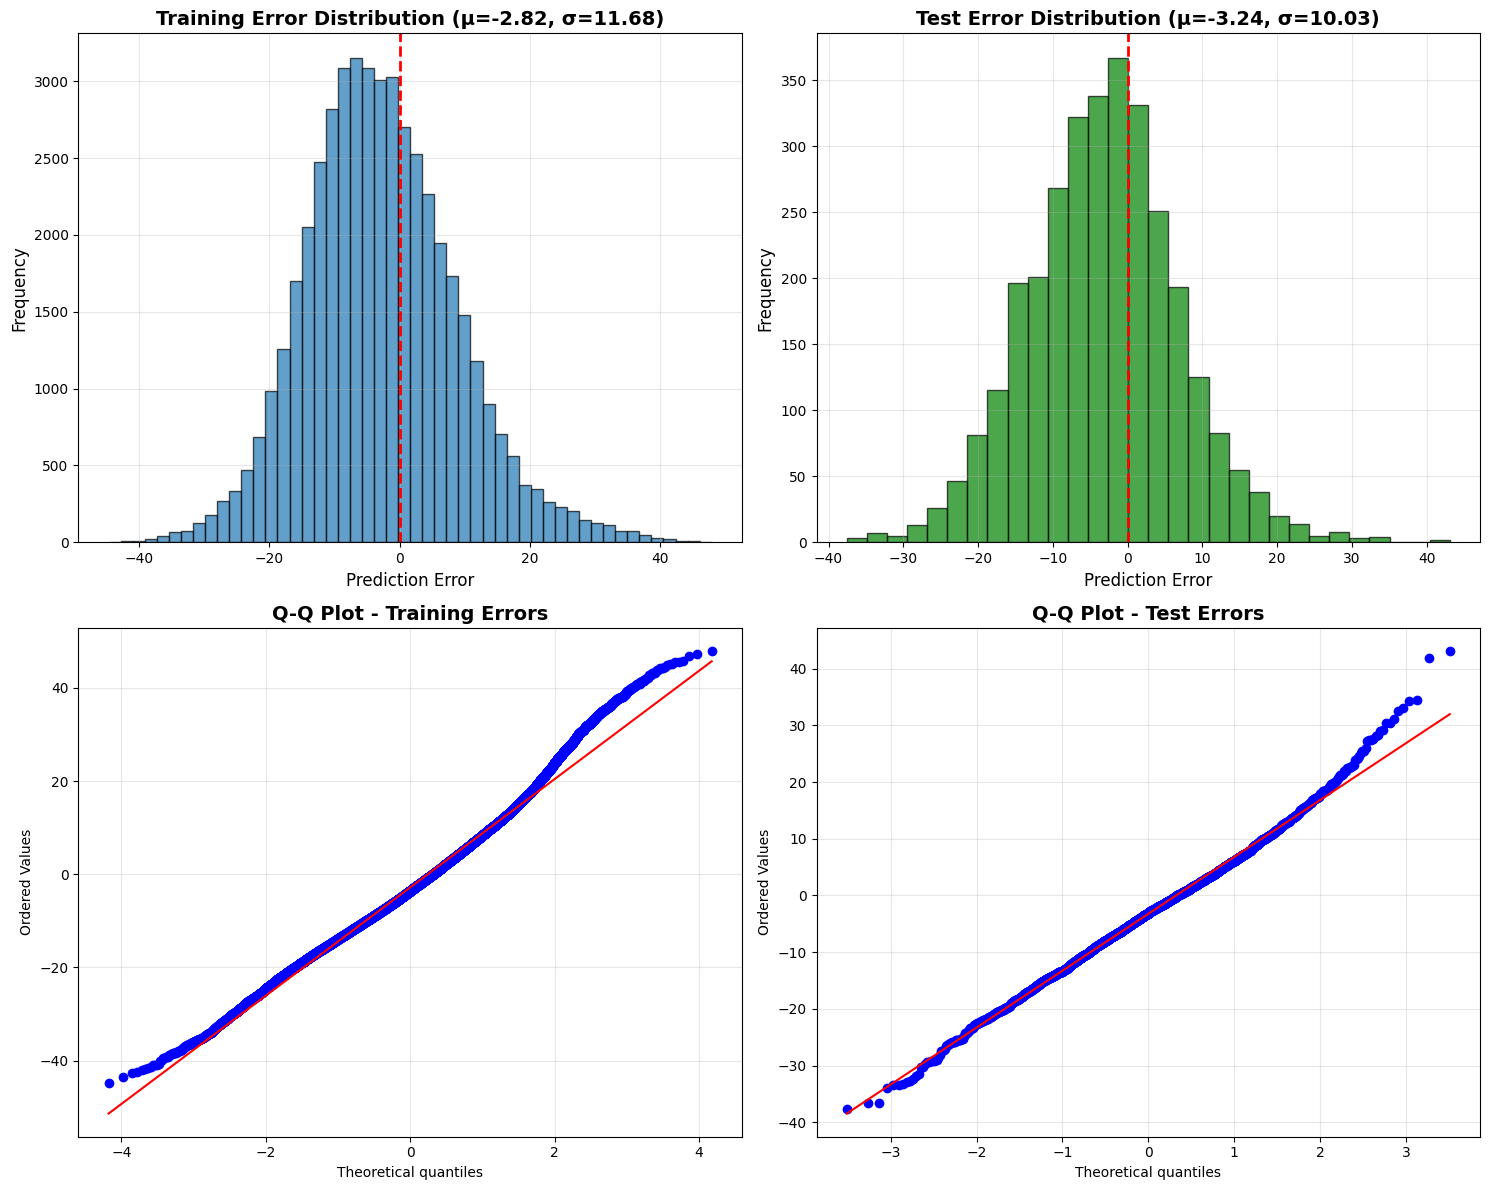


4. Metrics Comparison...


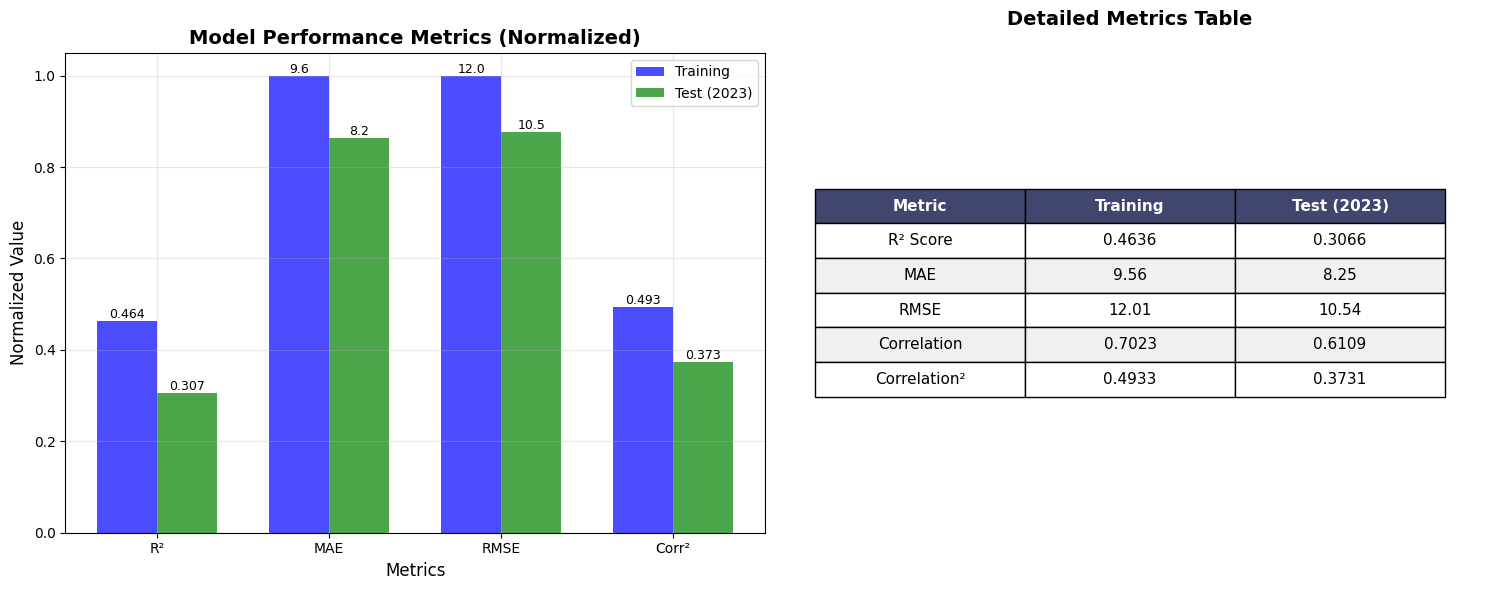


ANALYZING FEATURE IMPORTANCE...


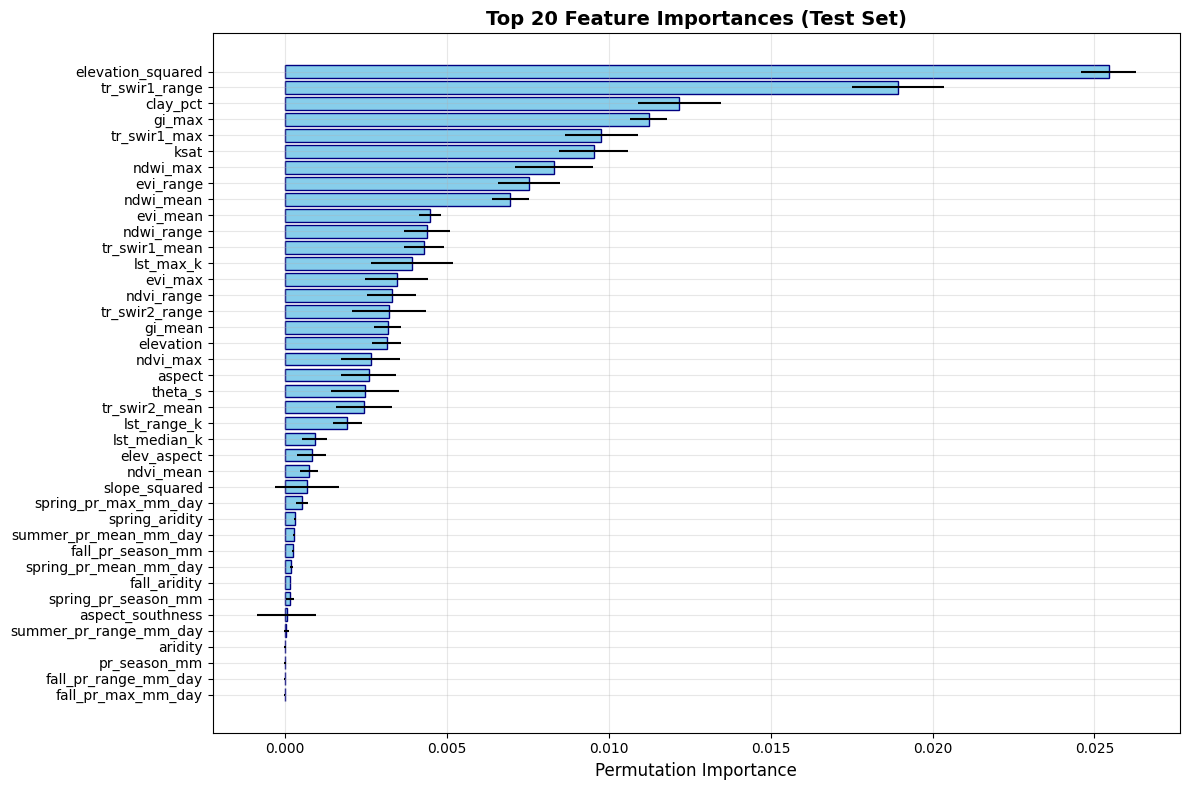


SAVING MODEL...
Model saved as 'final_soybean_yield_model.h5'
Scalers saved as 'scaler_X.pkl' and 'scaler_y.pkl'

ANALYSIS COMPLETE!


In [39]:
# Comprehensive Deep Neural Network for Soybean Yield Prediction
# This script includes hyperparameter tuning, training, evaluation, and visualization

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')



# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ---- YEAR SPLIT CONFIG (edit these anytime) ----
TEST_YEAR = 2023       # held-out test year
VAL_YEARS = [2014, 2016, 2024]     # one or more validation years


print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# =====================================================
# 1. DATA PREPARATION
# =====================================================

def prepare_data(df_soybeans, feature_columns, target_column='yield'):
    """
    Prepare data for training and testing
    """
    print(f"Dataset shape: {df_soybeans.shape}")

    # Separate Test_Year data for testing
    test_data = df_soybeans[df_soybeans['year'] == TEST_YEAR].copy()
    train_data = df_soybeans[df_soybeans['year'] != TEST_YEAR].copy()

    print(f"Training data (years != {TEST_YEAR}): {train_data.shape}")
    print(f"Test data (year = {TEST_YEAR}): {test_data.shape}")

    # Prepare features and target
    X_train = train_data[feature_columns]
    y_train = train_data[target_column]
    X_test = test_data[feature_columns]
    y_test = test_data[target_column]

    # Handle missing values if any
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_train.mean())  # Use training mean for test set

    # Scale features using RobustScaler (better for outliers)
    scaler_X = RobustScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Scale target variable
    scaler_y = RobustScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

    return (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled,
            scaler_X, scaler_y, X_train, y_train, X_test, y_test)

# =====================================================
# 2. MODEL ARCHITECTURE
# =====================================================

def create_model(input_dim,
                 hidden_layers=[1536, 768, 384, 192],
                 dropout_rate=0.15,
                 l1_reg=0.0000,
                 l2_reg=1e-5,
                 learning_rate=5e-4,
                 activation='gelu'):
    """
    Create a deep neural network with regularization
    """
    model = models.Sequential()

    # Input layer
    model.add(layers.Input(shape=(input_dim,)))

    # Add Batch Normalization at the beginning
    # model.add(layers.BatchNormalization())
    kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode="fan_in", distribution="truncated_normal")

    # Hidden layers with dropout and regularization
    for i, units in enumerate(hidden_layers):
        model.add(layers.Dense(
            units,
            activation=activation,
            kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
            # kernel_initializer='he_normal'
            kernel_initializer=kernel_initializer
        ))
        model.add(layers.BatchNormalization())

        # Add dropout (except for the last hidden layer)
        if i < len(hidden_layers) - 1:
            model.add(layers.Dropout(dropout_rate))
        else:
            model.add(layers.Dropout(dropout_rate * 0.5))  # Less dropout before output

    # Output layer
    model.add(layers.Dense(1, activation='linear'))

    # Compile model with custom optimizer
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.Huber(),
        metrics=['mae', 'mse']
    )

    return model

# =====================================================
# 3. HYPERPARAMETER CONFIGURATIONS
# =====================================================

# Best hyperparameters for challenging datasets with low predictability
best_params = {
    'hidden_layers': [256,128,64],  # Deeper network
    'dropout_rate': 0.35 ,
    'l1_reg': 0.0,
    'l2_reg': 0.001,
    'learning_rate': 0.0001,
    'batch_size': 2048,
    'epochs': 500,
    'activation': 'relu'  # ELU often works better than ReLU
}

# Alternative configurations to try
alternative_configs = [
    {
        'hidden_layers': [768, 384, 192, 96],
        'dropout_rate': 0.2,
        'l1_reg': 0.00005,
        'l2_reg': 0.00005,
        'learning_rate': 0.0003,
        'batch_size': 512,
        'activation': 'swish'
    },
    {
        'hidden_layers': [512, 512, 256, 256, 128],
        'dropout_rate': 0.3,
        'l1_reg': 0.0,
        'l2_reg': 0.0002,
        'learning_rate': 0.0001,
        'batch_size': 256,
        'activation': 'relu'
    }
]

# =====================================================
# 4. TRAINING WITH CALLBACKS
# =====================================================

def train_model(model, X_train, y_train, X_val, y_val, params, model_name='dnn_model'):
    """
    Train the model with advanced callbacks
    """
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_mae',
        patience=10,
        restore_best_weights=True,
        min_delta=1e-4,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_mae',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    checkpoint = ModelCheckpoint(
        f'{model_name}_best.h5',
        monitor='val_mae',
        save_best_only=True,
        verbose=0
    )

    # class OverfittingCallback(callbacks.Callback):
    #   def on_epoch_end(self, epoch, logs=None):
    #       gap = logs['val_loss'] - logs['loss']
    #       if gap > 0.15:  # If gap exceeds threshold
    #           print(f"\nStopping: Overfitting detected! Gap = {gap:.4f}")
    #           self.model.stop_training = True

    # Custom callback for learning curve data
    class LearningCurveCallback(callbacks.Callback):
        def on_train_begin(self, logs=None):
            self.losses = []
            self.val_losses = []
            self.maes = []
            self.val_maes = []

        def on_epoch_end(self, epoch, logs=None):
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))
            self.maes.append(logs.get('mae'))
            self.val_maes.append(logs.get('val_mae'))

    lc_callback = LearningCurveCallback()

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        callbacks=[early_stopping, reduce_lr, checkpoint, lc_callback],
        verbose=1
    )

    return history, lc_callback

# =====================================================
# 5. EVALUATION METRICS
# =====================================================

def evaluate_model(model, X_train, y_train, X_test, y_test, scaler_y):
    """
    Calculate comprehensive evaluation metrics
    """
    # Predictions
    y_train_pred = model.predict(X_train, verbose=0).ravel()
    y_test_pred = model.predict(X_test, verbose=0).ravel()

    # Calculate metrics for scaled data
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Correlation
    train_corr = np.corrcoef(y_train, y_train_pred)[0, 1]
    test_corr = np.corrcoef(y_test, y_test_pred)[0, 1]

    # Inverse transform to get metrics in original scale
    y_train_orig = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()
    y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
    y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).ravel()
    y_test_pred_orig = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).ravel()

    train_mae_orig = mean_absolute_error(y_train_orig, y_train_pred_orig)
    test_mae_orig = mean_absolute_error(y_test_orig, y_test_pred_orig)
    train_rmse_orig = np.sqrt(mean_squared_error(y_train_orig, y_train_pred_orig))
    test_rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_test_pred_orig))

    metrics = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mae': train_mae_orig,
        'test_mae': test_mae_orig,
        'train_rmse': train_rmse_orig,
        'test_rmse': test_rmse_orig,
        'train_corr': train_corr,
        'test_corr': test_corr,
        'train_corr_squared': train_corr**2,
        'test_corr_squared': test_corr**2
    }

    return metrics, y_train_pred_orig, y_test_pred_orig, y_train_orig, y_test_orig

# =====================================================
# 6. VISUALIZATION FUNCTIONS
# =====================================================

def plot_learning_curves(history, lc_callback):
    """
    Plot comprehensive learning curves
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Loss curves
    axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss (MSE)', fontsize=12)
    axes[0, 0].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # MAE curves
    axes[0, 1].plot(history.history['mae'], label='Training MAE', linewidth=2)
    axes[0, 1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('MAE', fontsize=12)
    axes[0, 1].set_title('Mean Absolute Error Over Time', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Log scale loss
    axes[1, 0].semilogy(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1, 0].semilogy(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Loss (log scale)', fontsize=12)
    axes[1, 0].set_title('Model Loss (Log Scale)', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Learning rate if available
    if 'lr' in history.history:
        axes[1, 1].plot(history.history['lr'], linewidth=2, color='green')
        axes[1, 1].set_xlabel('Epoch', fontsize=12)
        axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
        axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        # Overfitting detection plot
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        overfitting = np.array(val_loss) - np.array(train_loss)
        axes[1, 1].plot(overfitting, linewidth=2, color='red')
        axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[1, 1].set_xlabel('Epoch', fontsize=12)
        axes[1, 1].set_ylabel('Validation Loss - Training Loss', fontsize=12)
        axes[1, 1].set_title('Overfitting Detection', fontsize=14, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_predictions(y_train_true, y_train_pred, y_test_true, y_test_pred, metrics):
    """
    Plot actual vs predicted values with metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Training set scatter plot
    axes[0, 0].scatter(y_train_true, y_train_pred, alpha=0.5, s=10)
    axes[0, 0].plot([y_train_true.min(), y_train_true.max()],
                    [y_train_true.min(), y_train_true.max()],
                    'r--', lw=2)
    axes[0, 0].set_xlabel('Actual Yield', fontsize=12)
    axes[0, 0].set_ylabel('Predicted Yield', fontsize=12)
    axes[0, 0].set_title(f'Training Set (R² = {metrics["train_r2"]:.4f})',
                        fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    # Test set scatter plot
    axes[0, 1].scatter(y_test_true, y_test_pred, alpha=0.5, s=10, color='green')
    axes[0, 1].plot([y_test_true.min(), y_test_true.max()],
                    [y_test_true.min(), y_test_true.max()],
                    'r--', lw=2)
    axes[0, 1].set_xlabel('Actual Yield', fontsize=12)
    axes[0, 1].set_ylabel('Predicted Yield', fontsize=12)
    axes[0, 1].set_title(f'Test Set - {TEST_YEAR} (R² = {metrics["test_r2"]:.4f})',
                        fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    # Residuals plot - Training
    train_residuals = y_train_true - y_train_pred
    axes[1, 0].scatter(y_train_pred, train_residuals, alpha=0.5, s=10)
    axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1, 0].set_xlabel('Predicted Yield', fontsize=12)
    axes[1, 0].set_ylabel('Residuals', fontsize=12)
    axes[1, 0].set_title('Training Residuals', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # Residuals plot - Test
    test_residuals = y_test_true - y_test_pred
    axes[1, 1].scatter(y_test_pred, test_residuals, alpha=0.5, s=10, color='green')
    axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1, 1].set_xlabel('Predicted Yield', fontsize=12)
    axes[1, 1].set_ylabel('Residuals', fontsize=12)
    axes[1, 1].set_title(f'Test Residuals ({TEST_YEAR})', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('predictions_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_error_distribution(y_train_true, y_train_pred, y_test_true, y_test_pred):
    """
    Plot error distribution analysis
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    train_errors = y_train_true - y_train_pred
    test_errors = y_test_true - y_test_pred

    # Training error histogram
    axes[0, 0].hist(train_errors, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(x=0, color='r', linestyle='--', lw=2)
    axes[0, 0].set_xlabel('Prediction Error', fontsize=12)
    axes[0, 0].set_ylabel('Frequency', fontsize=12)
    axes[0, 0].set_title(f'Training Error Distribution (μ={np.mean(train_errors):.2f}, σ={np.std(train_errors):.2f})',
                        fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    # Test error histogram
    axes[0, 1].hist(test_errors, bins=30, edgecolor='black', alpha=0.7, color='green')
    axes[0, 1].axvline(x=0, color='r', linestyle='--', lw=2)
    axes[0, 1].set_xlabel('Prediction Error', fontsize=12)
    axes[0, 1].set_ylabel('Frequency', fontsize=12)
    axes[0, 1].set_title(f'Test Error Distribution (μ={np.mean(test_errors):.2f}, σ={np.std(test_errors):.2f})',
                        fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    # Q-Q plot for training
    from scipy import stats
    stats.probplot(train_errors, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot - Training Errors', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # Q-Q plot for test
    stats.probplot(test_errors, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot - Test Errors', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('error_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_metrics_comparison(metrics):
    """
    Create a comprehensive metrics visualization
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Metrics comparison bar plot
    metrics_names = ['R²', 'MAE', 'RMSE', 'Corr²']
    train_values = [metrics['train_r2'], metrics['train_mae'],
                   metrics['train_rmse'], metrics['train_corr_squared']]
    test_values = [metrics['test_r2'], metrics['test_mae'],
                  metrics['test_rmse'], metrics['test_corr_squared']]

    x = np.arange(len(metrics_names))
    width = 0.35

    # Normalize RMSE and MAE for visualization
    max_mae = max(metrics['train_mae'], metrics['test_mae'])
    max_rmse = max(metrics['train_rmse'], metrics['test_rmse'])

    train_values_norm = [metrics['train_r2'],
                         metrics['train_mae']/max_mae,
                         metrics['train_rmse']/max_rmse,
                         metrics['train_corr_squared']]
    test_values_norm = [metrics['test_r2'],
                       metrics['test_mae']/max_mae,
                       metrics['test_rmse']/max_rmse,
                       metrics['test_corr_squared']]

    bars1 = axes[0].bar(x - width/2, train_values_norm, width, label='Training', color='blue', alpha=0.7)
    bars2 = axes[0].bar(x + width/2, test_values_norm, width, label='Test (2023)', color='green', alpha=0.7)

    axes[0].set_xlabel('Metrics', fontsize=12)
    axes[0].set_ylabel('Normalized Value', fontsize=12)
    axes[0].set_title('Model Performance Metrics (Normalized)', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(metrics_names)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Add value labels on bars
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        if i == 0 or i == 3:  # R² and Corr²
            axes[0].text(bar1.get_x() + bar1.get_width()/2., height1,
                        f'{train_values[i]:.3f}', ha='center', va='bottom', fontsize=9)
            axes[0].text(bar2.get_x() + bar2.get_width()/2., height2,
                        f'{test_values[i]:.3f}', ha='center', va='bottom', fontsize=9)
        else:  # MAE and RMSE
            axes[0].text(bar1.get_x() + bar1.get_width()/2., height1,
                        f'{train_values[i]:.1f}', ha='center', va='bottom', fontsize=9)
            axes[0].text(bar2.get_x() + bar2.get_width()/2., height2,
                        f'{test_values[i]:.1f}', ha='center', va='bottom', fontsize=9)

    # Metrics table
    metrics_data = {
        'Metric': ['R² Score', 'MAE', 'RMSE', 'Correlation', 'Correlation²'],
        'Training': [f"{metrics['train_r2']:.4f}",
                    f"{metrics['train_mae']:.2f}",
                    f"{metrics['train_rmse']:.2f}",
                    f"{metrics['train_corr']:.4f}",
                    f"{metrics['train_corr_squared']:.4f}"],
        f'Test ({TEST_YEAR})': [f"{metrics['test_r2']:.4f}",
                       f"{metrics['test_mae']:.2f}",
                       f"{metrics['test_rmse']:.2f}",
                       f"{metrics['test_corr']:.4f}",
                       f"{metrics['test_corr_squared']:.4f}"]
    }
#2023
    # Create table
    table_data = []
    for i in range(len(metrics_data['Metric'])):
        table_data.append([metrics_data['Metric'][i],
                          metrics_data['Training'][i],
                          metrics_data[f'Test ({TEST_YEAR})'][i]])

    axes[1].axis('tight')
    axes[1].axis('off')
    table = axes[1].table(cellText=table_data,
                         colLabels=['Metric', 'Training', f'Test ({TEST_YEAR})'],
                         cellLoc='center',
                         loc='center',
                         colWidths=[0.3, 0.3, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2)

    # Style the header
    for i in range(3):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Alternate row colors
    for i in range(1, len(table_data) + 1):
        for j in range(3):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f0f0f0')

    axes[1].set_title('Detailed Metrics Table', fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# =====================================================
# 7. MAIN EXECUTION
# =====================================================

def main():
    """
    Main execution function
    """
    print("="*60)
    print("DEEP NEURAL NETWORK FOR SOYBEAN YIELD PREDICTION")
    print("="*60)

    # Define feature columns (update these based on your actual features)
#     feature_columns = [
#       "evi_max",
# "ndwi_max",
# "gi_range",
# "gi_mean",
# "ndvi_max",
# "evi_range",
# "ndwi_mean",
# "spring_aridity",
# "lst_range_k",
# "tr_swir2_mean"
#

    feature_columns = [
        'ndvi_mean', 'ndvi_max',
          'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
          'pr_season_mm', 'pr_max_mm_day', 'pr_range_mm_day',
          'aridity', 'theta_s', 'clay_pct', 'ksat', 'evi_mean', 'evi_max',
          'evi_range', 'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean', 'ndwi_max',
          'ndwi_range', 'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range',
          'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range', 'elevation', 'slope',
          'aspect', 'elevation_squared', 'slope_squared', 'elev_slope',
          'elev_aspect', 'slope_aspect', 'ndvi_pr', 'aspect_southness',
          'fall_aridity', 'fall_pr_max_mm_day', 'fall_pr_mean_mm_day',
          'fall_pr_range_mm_day', 'fall_pr_season_mm', 'spring_aridity',
          'spring_pr_max_mm_day', 'spring_pr_mean_mm_day',
          'spring_pr_range_mm_day', 'spring_pr_season_mm', 'summer_aridity',
          'summer_pr_max_mm_day', 'summer_pr_mean_mm_day',
          'summer_pr_range_mm_day', 'summer_pr_season_mm'
    ]


    # Filter to only include features that exist in your dataframe
    available_features = [col for col in feature_columns if col in df_soybeans.columns]
    print(f"\nUsing {len(available_features)} features: {available_features}")

    # Prepare data
    print("\n" + "="*60)
    print("PREPARING DATA...")
    print("="*60)

    (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled,
     scaler_X, scaler_y, X_train, y_train, X_test, y_test) = prepare_data(
        df_soybeans, available_features
    )

    # Split training data for validation
    # X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    #     X_train_scaled, y_train_scaled, test_size=0.15, random_state=42
    # )

    # print(f"Training set: {X_train_split.shape}")
    # print(f"Validation set: {X_val_split.shape}")
    # print(f"Test set (2023): {X_test_scaled.shape}")


    # ============================================================
    # TEMPORAL VALIDATION SPLIT (instead of random split)
    # ============================================================
    print("\n" + "="*60)
    print("CREATING TEMPORAL VALIDATION SPLIT...")
    print("="*60)

    # Get the original training data (before {TEST_YEAR}) with year column
    train_data = df_soybeans[df_soybeans['year'] != TEST_YEAR].copy()

    # Check available years
    available_years = sorted(train_data['year'].unique())
    print(f"Available years in training data: {available_years}")

    # Define validation year(s) - USE LAST YEAR(S) BEFORE test_year
    # Option 1: Single year validation (recommended if limited data)
    # val_years = [2022]  # ← ADJUST THIS based on your data

    # Option 2: Multi-year validation (if you have many years of data)
    val_years = VAL_YEARS # ← Uncomment and use if preferred

    print(f"Using year(s) {val_years} as validation set")

    # Create temporal masks
    val_mask = train_data['year'].isin(val_years)
    train_mask = ~val_mask

    # Get indices for each split
    val_indices = train_data[val_mask].index
    train_indices = train_data[train_mask].index

    # Map to positions in scaled arrays
    val_positions = [i for i, idx in enumerate(train_data.index) if idx in val_indices]
    train_positions = [i for i, idx in enumerate(train_data.index) if idx in train_indices]

    # Split the scaled data
    X_train_split = X_train_scaled[train_positions]
    X_val_split = X_train_scaled[val_positions]
    y_train_split = y_train_scaled[train_positions]
    y_val_split = y_train_scaled[val_positions]

    # Print split information
    print(f"\nTemporal Split Summary:")
    print(f"Training set: {X_train_split.shape[0]} samples")
    print(f"  Years: {sorted(train_data[train_mask]['year'].unique())}")
    print(f"Validation set: {X_val_split.shape[0]} samples")
    print(f"  Years: {sorted(train_data[val_mask]['year'].unique())}")
    print(f"Test set (2014): {X_test_scaled.shape[0]} samples")

    # Show year distribution
    print(f"\nTraining year distribution:")
    print(train_data[train_mask]['year'].value_counts().sort_index())
    print(f"\nValidation year distribution:")
    print(train_data[val_mask]['year'].value_counts().sort_index())

    # Create and train model
    print("\n" + "="*60)
    print("BUILDING AND TRAINING MODEL...")
    print("="*60)

    model = create_model(
        input_dim=X_train_scaled.shape[1],
        hidden_layers=best_params['hidden_layers'],
        dropout_rate=best_params['dropout_rate'],
        l1_reg=best_params['l1_reg'],
        l2_reg=best_params['l2_reg'],
        learning_rate=best_params['learning_rate'],
        activation=best_params['activation']
    )

    print("\nModel Architecture:")
    model.summary()

    print("\nTraining with parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")

    # Train the model
    history, lc_callback = train_model(
        model, X_train_split, y_train_split,
        X_val_split, y_val_split,
        best_params, model_name='soybean_yield_dnn'
    )

    # Evaluate model
    print("\n" + "="*60)
    print("EVALUATING MODEL...")
    print("="*60)

    metrics, y_train_pred, y_test_pred, y_train_orig, y_test_orig = evaluate_model(
        model, X_train_scaled, y_train_scaled,
        X_test_scaled, y_test_scaled, scaler_y
    )

    # Print metrics
    print("\n" + "="*60)
    print("FINAL RESULTS")
    print("="*60)
    print("\nTraining Set Performance:")
    print(f"  R² Score: {metrics['train_r2']:.4f}")
    print(f"  MAE: {metrics['train_mae']:.2f}")
    print(f"  RMSE: {metrics['train_rmse']:.2f}")
    print(f"  Correlation: {metrics['train_corr']:.4f}")
    print(f"  Correlation²: {metrics['train_corr_squared']:.4f}")

    print(f"\nTest Set Performance ({TEST_YEAR} Data):")
    print(f"  R² Score: {metrics['test_r2']:.4f}")
    print(f"  MAE: {metrics['test_mae']:.2f}")
    print(f"  RMSE: {metrics['test_rmse']:.2f}")
    print(f"  Correlation: {metrics['test_corr']:.4f}")
    print(f"  Correlation²: {metrics['test_corr_squared']:.4f}")

    # Generate all visualizations
    print("\n" + "="*60)
    print("GENERATING VISUALIZATIONS...")
    print("="*60)

    print("\n1. Learning Curves...")
    plot_learning_curves(history, lc_callback)

    print("\n2. Predictions Analysis...")
    plot_predictions(y_train_orig, y_train_pred, y_test_orig, y_test_pred, metrics)

    print("\n3. Error Distribution...")
    plot_error_distribution(y_train_orig, y_train_pred, y_test_orig, y_test_pred)

    print("\n4. Metrics Comparison...")
    plot_metrics_comparison(metrics)

    # Feature importance using permutation
    print("\n" + "="*60)
    print("ANALYZING FEATURE IMPORTANCE...")
    print("="*60)

    try:
        from sklearn.inspection import permutation_importance

        # Create a wrapper class for sklearn compatibility
        class KerasRegressor:
            def __init__(self, model):
                self.model = model

            def fit(self, X, y):
                # Already fitted, just return self
                return self

            def predict(self, X):
                return self.model.predict(X, verbose=0).ravel()

            def score(self, X, y):
                y_pred = self.predict(X)
                return r2_score(y, y_pred)

        # Wrap the Keras model
        sklearn_compatible_model = KerasRegressor(model)

        # Calculate permutation importance on test set
        perm_importance = permutation_importance(
            sklearn_compatible_model, X_test_scaled, y_test_scaled,
            n_repeats=10, random_state=42, n_jobs=-1,
            scoring='neg_mean_squared_error'
        )

        # Create feature importance plot
        fig, ax = plt.subplots(figsize=(12, 8))

        # Get top 20 features
        indices = np.argsort(perm_importance.importances_mean)[-40:]
        top_features = [available_features[i] for i in indices]
        importances = perm_importance.importances_mean[indices]
        std = perm_importance.importances_std[indices]

        ax.barh(range(len(indices)), importances, xerr=std, color='skyblue', edgecolor='navy')
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels(top_features)
        ax.set_xlabel('Permutation Importance', fontsize=12)
        ax.set_title('Top 20 Feature Importances (Test Set)', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()

    except Exception as e:
        print(f"Permutation importance failed: {e}")
        print("Using alternative feature importance method...")

        # Alternative: Calculate feature importance using gradient-based method
        import tensorflow as tf

        @tf.function
        def compute_gradients(X):
            X = tf.constant(X, dtype=tf.float32)
            with tf.GradientTape() as tape:
                tape.watch(X)
                predictions = model(X, training=False)
            return tape.gradient(predictions, X)

        # Compute gradients for test set
        gradients = compute_gradients(X_test_scaled[:1000])  # Use subset for speed

        # Calculate mean absolute gradients as importance
        feature_importance = np.mean(np.abs(gradients.numpy()), axis=0)

        # Create plot
        fig, ax = plt.subplots(figsize=(12, 8))

        # Get top 20 features
        indices = np.argsort(feature_importance)[-40:]
        top_features = [available_features[i] for i in indices]
        importances = feature_importance[indices]

        ax.barh(range(len(indices)), importances, color='lightcoral', edgecolor='darkred')
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels(top_features)
        ax.set_xlabel('Gradient-based Feature Importance', fontsize=12)
        ax.set_title('Top 20 Feature Importances (Test Set)', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Save the model
    print("\n" + "="*60)
    print("SAVING MODEL...")
    print("="*60)
    model.save('final_soybean_yield_model.h5')
    print("Model saved as 'final_soybean_yield_model.h5'")

    # Save scalers for future use
    import joblib
    joblib.dump(scaler_X, 'scaler_X.pkl')
    joblib.dump(scaler_y, 'scaler_y.pkl')
    print("Scalers saved as 'scaler_X.pkl' and 'scaler_y.pkl'")

    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)

    return model, metrics, history

# =====================================================
# 8. ADVANCED ENSEMBLE APPROACH (OPTIONAL)
# =====================================================

def train_ensemble_models(X_train, y_train, X_test, y_test, n_models=5):
    """
    Train multiple models with different initializations for ensemble
    """
    print("\n" + "="*60)
    print("TRAINING ENSEMBLE MODELS...")
    print("="*60)

    models = []
    predictions_train = []
    predictions_test = []

    for i in range(n_models):
        print(f"\nTraining model {i+1}/{n_models}...")

        # Set different random seed for each model
        tf.random.set_seed(42 + i)
        np.random.seed(42 + i)

        # Create model with slight variations
        model = create_model(
            input_dim=X_train.shape[1],
            hidden_layers=best_params['hidden_layers'],
            dropout_rate=best_params['dropout_rate'] + np.random.uniform(-0.05, 0.05),
            l1_reg=best_params['l1_reg'],
            l2_reg=best_params['l2_reg'],
            learning_rate=best_params['learning_rate'] * np.random.uniform(0.8, 1.2),
            activation=best_params['activation']
        )

        # Train with different data split
        X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
            X_train, y_train, test_size=0.15, random_state=42+i
        )

        history, _ = train_model(
            model, X_train_split, y_train_split,
            X_val_split, y_val_split,
            best_params, model_name=f'ensemble_model_{i}'
        )

        models.append(model)
        predictions_train.append(model.predict(X_train, verbose=0).ravel())
        predictions_test.append(model.predict(X_test, verbose=0).ravel())

    # Ensemble predictions (average)
    ensemble_train_pred = np.mean(predictions_train, axis=0)
    ensemble_test_pred = np.mean(predictions_test, axis=0)

    # Calculate ensemble metrics
    ensemble_train_r2 = r2_score(y_train, ensemble_train_pred)
    ensemble_test_r2 = r2_score(y_test, ensemble_test_pred)

    print("\n" + "="*60)
    print("ENSEMBLE RESULTS:")
    print(f"  Training R²: {ensemble_train_r2:.4f}")
    print(f"  Test R² ({TEST_YEAR}): {ensemble_test_r2:.4f}")
    print("="*60)
#2023
    return models, ensemble_train_pred, ensemble_test_pred

# Run the main function
if __name__ == "__main__":
    # Assuming df_soybeans is already loaded in your environment
    # If not, uncomment and modify the following line:
    # df_soybeans = pd.read_csv('your_soybean_data.csv')

    model, metrics, history = main()

    # Optional: Train ensemble for potentially better performance
    # Note: This will take longer but might improve results
    # Uncomment the following lines if you want to try ensemble approach:

    # print("\n" + "="*60)
    # print("OPTIONAL: ENSEMBLE APPROACH")
    # print("="*60)
    # response = input("Do you want to train an ensemble of models? (y/n): ")
    # if response.lower() == 'y':
    #     # Prepare data again for ensemble
    #     (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled,
    #      scaler_X, scaler_y, _, _, _, _) = prepare_data(df_soybeans, available_features)
    #
    #     ensemble_models, ensemble_train_pred, ensemble_test_pred = train_ensemble_models(
    #         X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled
    #     )

In [ ]:
df_soybeans.keys()

Index(['x', 'y', 'yield', 'field', 'year', 'ndvi_mean', 'ndvi_max',
       'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'theta_s', 'clay_pct', 'ksat', 'evi_mean', 'evi_max',
       'evi_range', 'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean', 'ndwi_max',
       'ndwi_range', 'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range',
       'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range', 'elevation', 'slope',
       'aspect', 'elevation_squared', 'slope_squared', 'elev_slope',
       'elev_aspect', 'slope_aspect', 'ndvi_pr', 'aspect_southness',
       'fall_aridity', 'fall_pr_max_mm_day', 'fall_pr_mean_mm_day',
       'fall_pr_range_mm_day', 'fall_pr_season_mm', 'spring_aridity',
       'spring_pr_max_mm_day', 'spring_pr_mean_mm_day',
       'spring_pr_range_mm_day', 'spring_pr_season_mm', 'summer_aridity',
       'summer_pr_max_mm_day', 'summer_pr_mean_mm_day',
       'summer_pr_range_mm